# Researching best params for new approach
On this notebook, we try to find the best params for our suggested approach on ICQ classifier.

## Setup

### Importing libraries and helper methods

In [1]:
import sys
import os
sys.path.append(os.path.abspath('../../'))
sys.path.append(os.path.abspath('../../models/'))
sys.path.append(os.path.abspath('../../helpers/'))

In [2]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

# We're ignoring some warning from sklearn.metrics.classification_report
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)

In [3]:
import numpy as np
#from helpers.utils import print_metrics
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from helpers.database_helpers import get_stratified_kfold
from models.icq_estimators import IcqClassifier
from helpers.icq_executions import execute_classifier_split_input_weight_normal_sigma_q, execute_classifier_split_input_weight_polar_sigma_q

In [4]:
import matplotlib.pyplot as plt

### Setting up database, k-fold and random seed

In [5]:
# Dá pra usar caminhos relativos, não tem pra quê colocar tudo de uma vez não
path_to_datasets = "Datasets_template_exp/" 
dataset_name = "circles.npy"

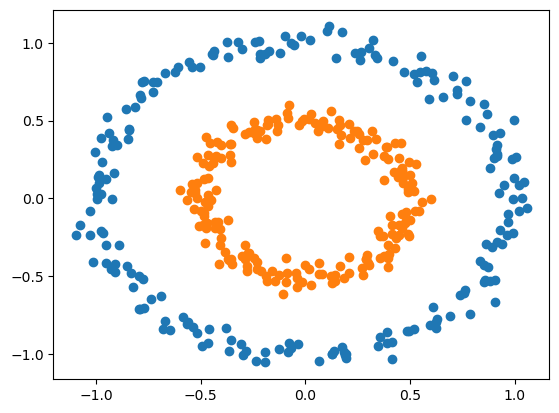

In [6]:
seed = 40
dataset = np.load( path_to_datasets + dataset_name)

X,y = dataset[:,:-1],dataset[:,-1]

X0 = X[y == 0]
X1 = X[y == 1]

plt.plot(X0[:,0],X0[:,1],'o')
plt.plot(X1[:,0],X1[:,1],'o')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
cv = get_stratified_kfold(random_seed=seed)

## Search for best params on sigmaQ = sigmaX + sigmaY + sigmaZ

### Model

In [7]:
icq = IcqClassifier(classifier_function=execute_classifier_split_input_weight_normal_sigma_q,
                    max_iter=2000, 
                    random_seed=seed, 
                    plot_graphs_and_metrics=False,
                    do_classes_refit=False)

In [8]:
print(icq.get_params().keys())
print(icq.do_classes_refit)

dict_keys(['accuracy_succ', 'classifier_function', 'do_classes_refit', 'learning_rate', 'max_iter', 'plot_graphs_and_metrics', 'random_seed', 'reset_weights_epoch', 'sigma_q_weights'])
False


### Search for Sigma Q Params
First research on the new approach (having weights on U operator and inputs on rho env) - varying SigmaQ params

#### Integer params
On this phase, we're dealing only with integer params, i.e. [1, 1, 1], [2, 2, 2], etc.

In [9]:
params = dict()
params["classifier_function"] = [execute_classifier_split_input_weight_normal_sigma_q]
params["max_iter"] = [2000]
params["random_seed"] = [seed]

# Prefiro recolocar esse parâmetro para poder ter certeza que ele vai executar com os que eu quero
params["do_classes_refit"] = [False]

# Coloquei 0.99 pq não precisa ser tão preciso assim, já que só temos 2 classes
params["accuracy_succ"] = [0.99]

In [10]:
params["sigma_q_weights"] = []
for i in range(0, 15, 1):
    for j in range(0, 15, 1):
        for k in range(0, 15, 1):
                params["sigma_q_weights"].append([i, j, k])

In [11]:
%%time
busca = RandomizedSearchCV(icq, params, n_iter=50, scoring='accuracy', n_jobs=-1, cv=cv, random_state=seed, verbose=60)

# # Executa busca
resultado = busca.fit(X_train, y_train)

# Resume resultados
print('Resultados busca - ICQ Alterado')
print('Melhor acurácia: %s' % resultado.best_score_)
print('Melhor hiperparâmetro: %s' % resultado.best_params_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Resultados busca - ICQ Alterado
Melhor acurácia: 0.5125
Melhor hiperparâmetro: {'sigma_q_weights': [3, 10, 6], 'random_seed': 40, 'max_iter': 2000, 'do_classes_refit': False, 'classifier_function': <function execute_classifier_split_input_weight_normal_sigma_q at 0x000002DBDE898790>, 'accuracy_succ': 0.99}
Wall time: 4h 46min 9s


#### Float params
On this phase, we'll deal with Sigma Q params as floats [0,1].

In [12]:
params = dict()
params["classifier_function"] = [execute_classifier_split_input_weight_normal_sigma_q]
params["max_iter"] = [2000]
params["random_seed"] = [seed]
# Prefiro recolocar esse parâmetro para poder ter certeza que ele vai executar com os que eu quero
params["do_classes_refit"] = [False]

# Coloquei 0.99 pq não precisa ser tão preciso assim, já que só temos 2 classes
params["accuracy_succ"] = [0.99]

In [13]:
params["sigma_q_weights"] = []
for i in np.arange(0, 1, 0.1):
    for j in np.arange(0, 1, 0.1):
        for k in np.arange(0, 1, 0.1):
                if not(i == j and j == k and i == 1):
                    params["sigma_q_weights"].append([i, j, k])

In [14]:
%%time
busca = RandomizedSearchCV(icq, params, n_iter=50, scoring='accuracy', n_jobs=-1, cv=cv, random_state=seed, verbose=60)

# Executa busca
resultado = busca.fit(X_train, y_train)

# Resume resultados
print('Resultados busca - ICQ Alterado')
print('Melhor acurácia: %s' % resultado.best_score_)
print('Melhor hiperparâmetro: %s' % resultado.best_params_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Resultados busca - ICQ Alterado
Melhor acurácia: 0.50625
Melhor hiperparâmetro: {'sigma_q_weights': [0.5, 0.9, 0.4], 'random_seed': 40, 'max_iter': 2000, 'do_classes_refit': False, 'classifier_function': <function execute_classifier_split_input_weight_normal_sigma_q at 0x000002DBDE898790>, 'accuracy_succ': 0.99}
Wall time: 4h 21min 24s


### Search for Learning Rates
Since we didn't have any result varying the Sigma Q, let's now vary the learning rate param and see what happens.

#### Small subset of learning rates

In [15]:
params = dict()
params["sigma_q_weights"] = [[1,1,1]]
params["classifier_function"] = [execute_classifier_split_input_weight_normal_sigma_q]
params["max_iter"] = [2000]
params["random_seed"] = [seed]
params["accuracy_succ"] = [1.0]
params["learning_rate"] = [0.1, 0.01, 0.001, 0.2, 0.02, 0.002, 0.0001]

In [ ]:
%%time
busca = RandomizedSearchCV(icq, params, n_iter=10, scoring='accuracy', n_jobs=-1, cv=cv, random_state=seed)

# Executa busca
resultado = busca.fit(X_train, y_train)

# Resume resultados
print('Resultados busca - ICQ Alterado')
print('Melhor acurácia: %s' % resultado.best_score_)
print('Melhor hiperparâmetro: %s' % resultado.best_params_)

#### Biggest subset of learning rates
Let's now try with a biggest subset of learning rates, which will take longer, but hopefully will earn better results. We'll try with:
- [0.1, 0.2, ..., 0.9]; +
- [0.01, 0.2, ..., 0.9]; +
- [0.001, 0.002, ..., 0.009]; +
- [0.0001, 0.0002, ..., 0.0009]; +
- [0.00001, 0.00002, ..., 0.00009]; +
- [0.000001, 0.000002, ..., 0.000009];

In [ ]:
params = dict()
params["sigma_q_weights"] = [[1,1,1]]
params["classifier_function"] = [execute_classifier_split_input_weight_normal_sigma_q]
params["max_iter"] = [2000]
params["random_seed"] = [seed]
params["accuracy_succ"] = [1.0]
params["learning_rate"] = []
for i in range (1, 10):
    params["learning_rate"].append(0.1 * i)
    params["learning_rate"].append(0.01 * i)
    params["learning_rate"].append(0.001 * i)
    params["learning_rate"].append(0.0001 * i)
    params["learning_rate"].append(0.00001 * i)
    params["learning_rate"].append(0.000001 * i)

In [ ]:
%%time
busca = GridSearchCV(icq, params, scoring='accuracy', n_jobs=-1, cv=cv, verbose=10)

# Executa busca
resultado = busca.fit(X_train, y_train)

# Resume resultados
print('Resultados busca - ICQ Alterado')
print('Melhor acurácia: %s' % resultado.best_score_)
print('Melhor hiperparâmetro: %s' % resultado.best_params_)

### Search for best learning rate for best Sigma Q param 

In [ ]:
params = dict()
params["sigma_q_weights"] = [[0.7, 0.4, 0.0]]
params["classifier_function"] = [execute_classifier_split_input_weight_normal_sigma_q]
params["max_iter"] = [2000]
params["random_seed"] = [seed]
params["accuracy_succ"] = [1.0]

In [ ]:
params["learning_rate"] = []
for i in range (1, 10):
    params["learning_rate"].append(0.1 * i)
    params["learning_rate"].append(0.01 * i)
    params["learning_rate"].append(0.001 * i)
    params["learning_rate"].append(0.0001 * i)
    params["learning_rate"].append(0.00001 * i)
    params["learning_rate"].append(0.000001 * i)

In [ ]:
%%time
busca = GridSearchCV(icq, params, scoring='accuracy', n_jobs=-1, cv=cv, verbose=10)

# Executa busca
resultado = busca.fit(X_train, y_train)

# Resume resultados
print('Resultados busca - ICQ Alterado')
print('Melhor acurácia: %s' % resultado.best_score_)
print('Melhor hiperparâmetro: %s' % resultado.best_params_)

### Search for best Sigma Q using best Learning Rate param

In [ ]:
params = dict()
params["sigma_q_weights"] = []
params["classifier_function"] = [execute_classifier_split_input_weight_normal_sigma_q]
params["max_iter"] = [2000]
params["random_seed"] = [seed]
params["accuracy_succ"] = [1.00]
params["learning_rate"] = [0.002]
for i in np.arange(0, 1, 0.1):
    for j in np.arange(0, 1, 0.1):
        for k in np.arange(0, 1, 0.1):
                if not(i == j and j == k and i == 1):
                    params["sigma_q_weights"].append([i, j, k])

In [ ]:
%%time
busca = RandomizedSearchCV(icq, params, n_iter=50, scoring='accuracy', n_jobs=-1, cv=cv, random_state=seed, verbose=60)

# Executa busca
resultado = busca.fit(X_train, y_train)

# Resume resultados
print('Resultados busca - ICQ Alterado')
print('Melhor acurácia: %s' % resultado.best_score_)
print('Melhor hiperparâmetro: %s' % resultado.best_params_)

## Search for best params on sigmaQ = rx\*sigmaX + ry\*sigmaY + rz\*sigmaZ

In [ ]:
icq = OneVsRestClassifier(IcqClassifier(classifier_function=execute_classifier_split_input_weight_polar_sigma_q, max_iter=2000, random_seed=seed, plot_graphs_and_metrics=False))

In [ ]:
params = dict()
params["classifier_function"] = [execute_classifier_split_input_weight_polar_sigma_q]
params["max_iter"] = [2000]
params["random_seed"] = [seed]
params["accuracy_succ"] = [1.00]

In [ ]:
params["sigma_q_weights"] = []
for i in np.arange(0, np.pi, 0.1):
    for j in np.arange(0, np.pi, 0.1):
        params["sigma_q_weights"].append([1, i, j])

In [ ]:
params["learning_rate"] = []
for i in range (1, 10):
    params["learning_rate"].append(0.1 * i)
    params["learning_rate"].append(0.01 * i)
    params["learning_rate"].append(0.001 * i)
    params["learning_rate"].append(0.0001 * i)
    params["learning_rate"].append(0.00001 * i)
    params["learning_rate"].append(0.000001 * i)

In [ ]:
%%time
busca = RandomizedSearchCV(icq, params, n_iter=70, scoring='accuracy', n_jobs=-1, cv=cv, random_state=seed, verbose=60)

# Executa busca
resultado = busca.fit(X_train, y_train)

# Resume resultados
print('Resultados busca - ICQ Alterado')
print('Melhor acurácia: %s' % resultado.best_score_)
print('Melhor hiperparâmetro: %s' % resultado.best_params_)